In [39]:
#!/usr/bin/env python

# make sure to install these packages before running:
# pip install pandas
# pip install numpy
# pip install sodapy

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sodapy import Socrata

# NYPD Arrest Data (Year to Date)
socrata_dataset_identifier = "uip8-fykc"
socrata_domain = "data.cityofnewyork.us"

# read application token
with open('app-token.txt', 'r') as fp:
    contents = fp.read()
socrata_token = contents

client = Socrata(socrata_domain, socrata_token)

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
#client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata('data.cityofnewyork.us',
#                  MyAppToken,
#                  username="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
#results = client.get(socrata_dataset_identifier, limit=1000)

# Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(results)

In [3]:
# Metadata
metadata = client.get_metadata(socrata_dataset_identifier)
metadata_columns = [x['name'] for x in metadata['columns']]

In [5]:
# Metadata for a particular column
meta_arrest_date = [x for x in metadata['columns'] if x['name'] == 'ARREST_DATE'][0]
#meta_arrest_date

In [7]:
# get date range of data
# string is returned
most_recent_date = meta_arrest_date['cachedContents']['largest']
oldest_date = meta_arrest_date['cachedContents']['smallest']
num_of_results = meta_arrest_date['cachedContents']['non_null']
# print(most_recent_date)
# print(oldest_date)
#print("Total number of non-null results: "+ str(num_of_results))

In [ ]:
# filter dataset
results = client.get(socrata_dataset_identifier, 
                     where="ARREST_DATE > '2019-01-01T00:00:00.000'",
                     # select="column1,column2,etc",
                     # order="column1 ASC",
                     # can also do other operations 
                     limit=1000)


print("Number of results downloaded: " + str(len(results)))

# results_df = pd.DataFrame.from_records(results)
# results_df

In [8]:
# loop through the results

loop_size = 1000
num_loops = 4

data = []

for i in range(num_loops):
    results = client.get(socrata_dataset_identifier, 
                         where="ARREST_DATE >= '2019-01-01T00:00:00.000'",
                         # select="column1,column2,etc",
                         # order="column1 ASC",
                         # can also do other operations 
                         limit=loop_size,
                         offset=loop_size * i)
    data.extend(results)
    #print("Loop number: " + str(i))

In [18]:
results_df = pd.DataFrame(data)
results_df.head()

,age_group,arrest_boro,arrest_date,arrest_key,arrest_precinct,jurisdiction_code,ky_cd,latitude,law_cat_cd,law_code,longitude,ofns_desc,pd_cd,pd_desc,perp_race,perp_sex,x_coord_cd,y_coord_cd
0,25-44,M,2019-09-30T00:00:00.000,203078287,9,0,105.0,40.72420015400007,F,PL 1600500,-73.97722564299994,ROBBERY,397,"ROBBERY,OPEN AREA UNCLASSIFIED",BLACK HISPANIC,M,990563,203120
1,18-24,Q,2019-09-30T00:00:00.000,203072424,113,0,121.0,40.68997415500007,F,PL 1450502,-73.79676854399997,CRIMINAL MISCHIEF & RELATED OF,268,CRIMINAL MIS 2 & 3,BLACK,M,1040611,190715
2,18-24,S,2019-09-30T00:00:00.000,203061215,122,0,347.0,40.60612948000005,M,VTL11920U3,-74.07657042999993,INTOXICATED & IMPAIRED DRIVING,905,"INTOXICATED DRIVING,ALCOHOL",WHITE,M,962989,160112
3,25-44,S,2019-09-30T00:00:00.000,203061218,120,0,105.0,40.645022746000045,F,PL 1601502,-74.077216847,ROBBERY,397,"ROBBERY,OPEN AREA UNCLASSIFIED",WHITE HISPANIC,M,962822,174282
4,18-24,Q,2019-09-30T00:00:00.000,203063729,106,0,105.0,40.68426580100004,F,PL 1601001,-73.81513849899994,ROBBERY,397,"ROBBERY,OPEN AREA UNCLASSIFIED",ASIAN / PACIFIC ISLANDER,M,1035521,188624


In [21]:
# unique boroughs
unique_results = results_df.arrest_boro.unique()
print(unique_results)
print()
print(results_df['arrest_boro'].value_counts())
print()
print(results_df.shape)

print()
print(results_df.dtypes)

['M' 'Q' 'S' 'B' 'K']

K    1096
M    1009
B     889
Q     816
S     190
Name: arrest_boro, dtype: int64

(4000, 18)

age_group            object
arrest_boro          object
arrest_date          object
arrest_key           object
arrest_precinct      object
jurisdiction_code    object
ky_cd                object
latitude             object
law_cat_cd           object
law_code             object
longitude            object
ofns_desc            object
pd_cd                object
pd_desc              object
perp_race            object
perp_sex             object
x_coord_cd           object
y_coord_cd           object
dtype: object


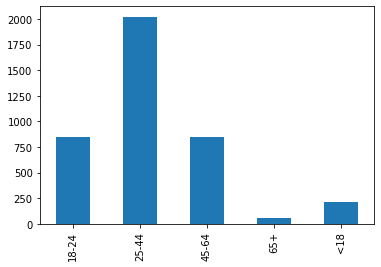

In [37]:
age_group_labels = sorted(results_df.age_group.unique())

results_df['age_group'].value_counts()[age_group_labels].plot(kind='bar')
#results_df.hist(column='age_group',bins=3)

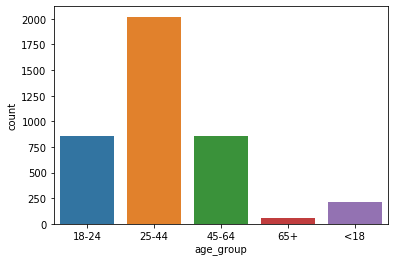

In [46]:
sns.countplot(results_df['age_group'],
              order=age_group_labels)